# Visualising CANGRD Data for Canadian Climate Variables

Data available from CANGRD is in GeoTiff format and has to be interated with and opened by a python library called Rasterio. The CANGRD dataset uses Polar Stereographic Coordinates.

In [ ]:
conda install gdal --channel conda-forge

In [ ]:
conda install -c conda-forge poppler

In [37]:
conda install pandas

Retrieving notices: ...working... done
Channels:
 - defaults
 - conda-forge
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.9.2               |  py312hecd8cb5_0         1.1 MB
    ------------------------------------------------------------
                                           Total:         1.1 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2024.8.30~ --> pkgs/main/osx-64::certifi-2024.8.30-py312hecd8cb5_0 
  conda              conda-forge::conda-24.9.2-py312hb4010~ --> pkgs/main::conda-24.9.2-py312hecd8cb5_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Execu

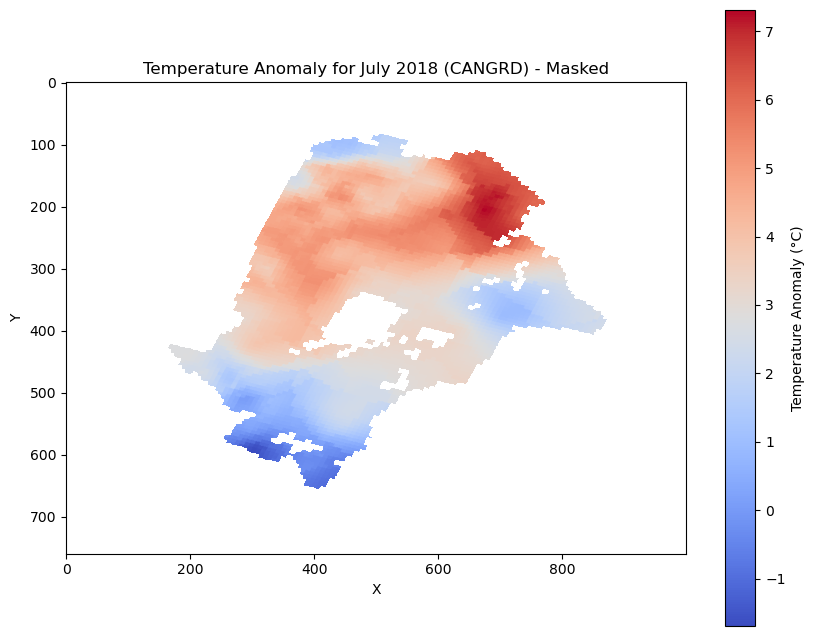

In [8]:
import rasterio
import rasterio.features
import rasterio.warp
import matplotlib.pyplot as plt
import numpy as np

with rasterio.open('/Users/maxMax/Desktop/Datasets/CANGRD_hist_monthly_anom_ps50km_TMEAN_2018-12.tif') as dataset: #importing dataset using rasterio
    
    temperature_data = dataset.read(1) #all data appears to be in first 'band'

    metadata = { #printing the metadata for debugging and plotting purposess
        'count': dataset.count,
        'width': dataset.width,
        'height': dataset.height,
        'bounds': dataset.bounds,
        'transform': dataset.transform,
        'crs': dataset.crs
    }

temperature_data_masked = np.ma.masked_where(temperature_data == 9999.9, temperature_data) #becaause the empty cell values here are given a value of 9999.9, they skew the values on the plot and make it impossible to differentiate variables on land therefore they are masked

plt.figure(figsize=(10, 8)) #plotting
plt.imshow(temperature_data_masked, cmap='coolwarm')
plt.colorbar(label="Temperature Anomaly (°C)")
plt.title("Temperature Anomaly for July 2018 (CANGRD) - Masked")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Jupyter Notebook had isssues running the Rasterio library because it could not find the correct library in Poppler. It tries to find libpoppler.126.dylib when the only available is libpoppler.136.dylib. To fix this, open to console (terminal) and run the following command:

In [ ]:
ln -s /usr/local/lib/libpoppler.136.dylib /usr/local/lib/libpoppler.126.dylib

The documentation on CANGRD defines the coordinate system used ("The grid is a 125 (columns) by 95 (rows) matrix, where the SW corner (0,0) is at 40.05°N latitude and 129.85°W longitude. The projection is true at 60.0°N and centered on 110.0°W") which allowed me to transform the x and y axes into decimal coordinates (WSG84):

/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_8207/3425908532.py:31: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(src_proj, dst_proj, x_proj_flat, y_proj_flat)#converting to WSG84 coordinates using pyproj
/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_8207/3425908532.py:37: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon, lat, masked_data, cmap='coolwarm', shading='auto')


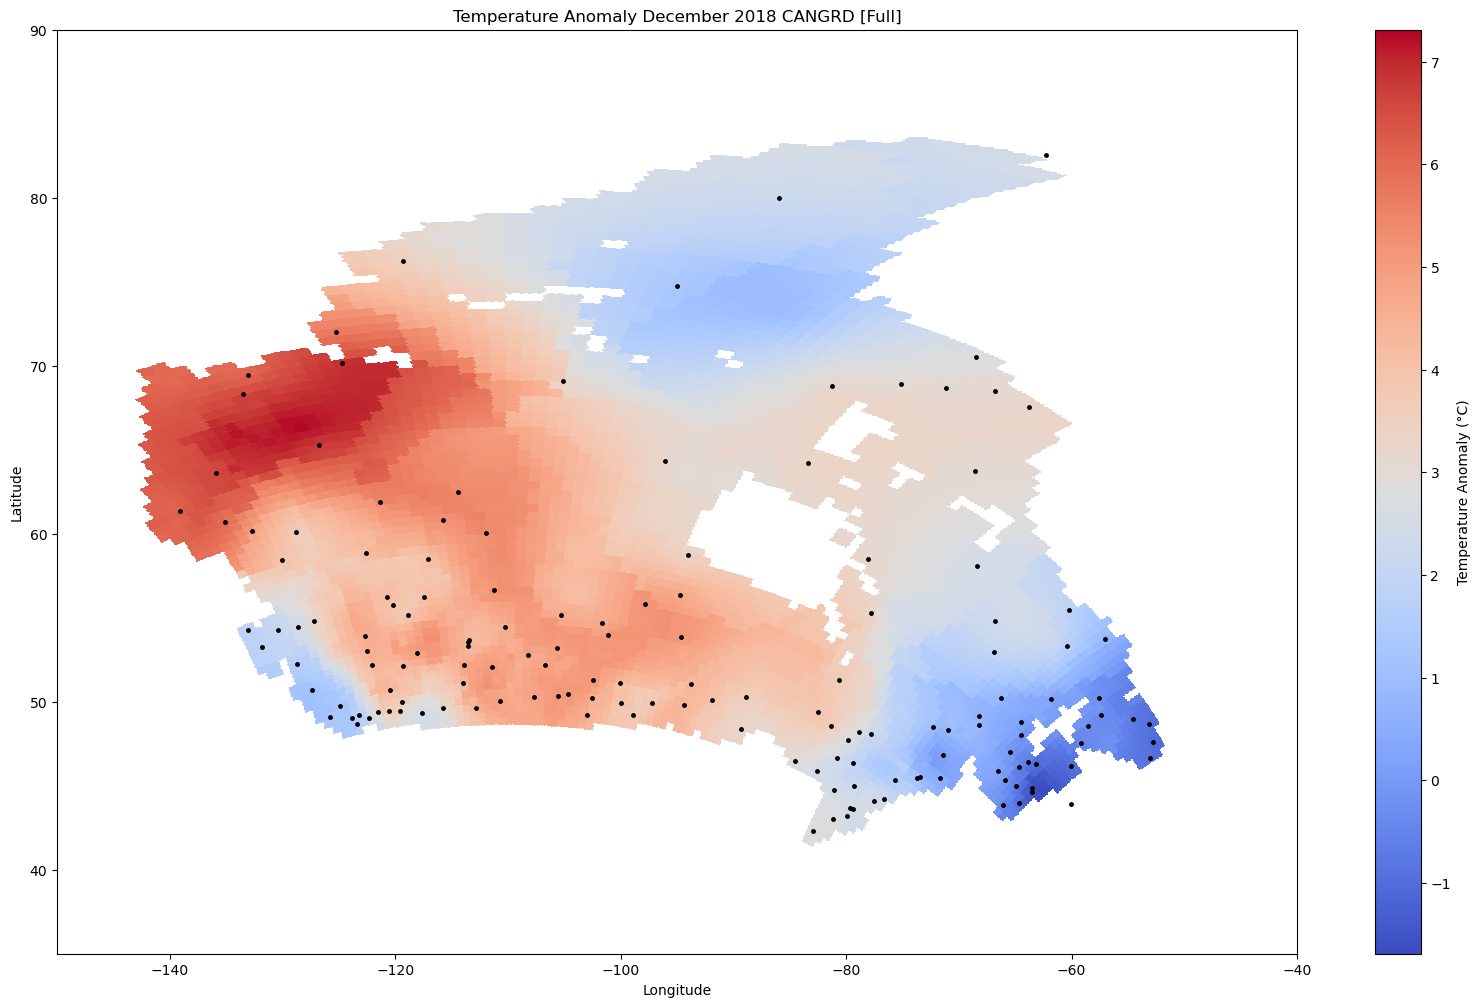

/var/folders/h5/wr1_5h5s2sd3jw2htzn509v00000gp/T/ipykernel_8207/3425908532.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon, lat, masked_data, cmap='coolwarm', shading='auto')


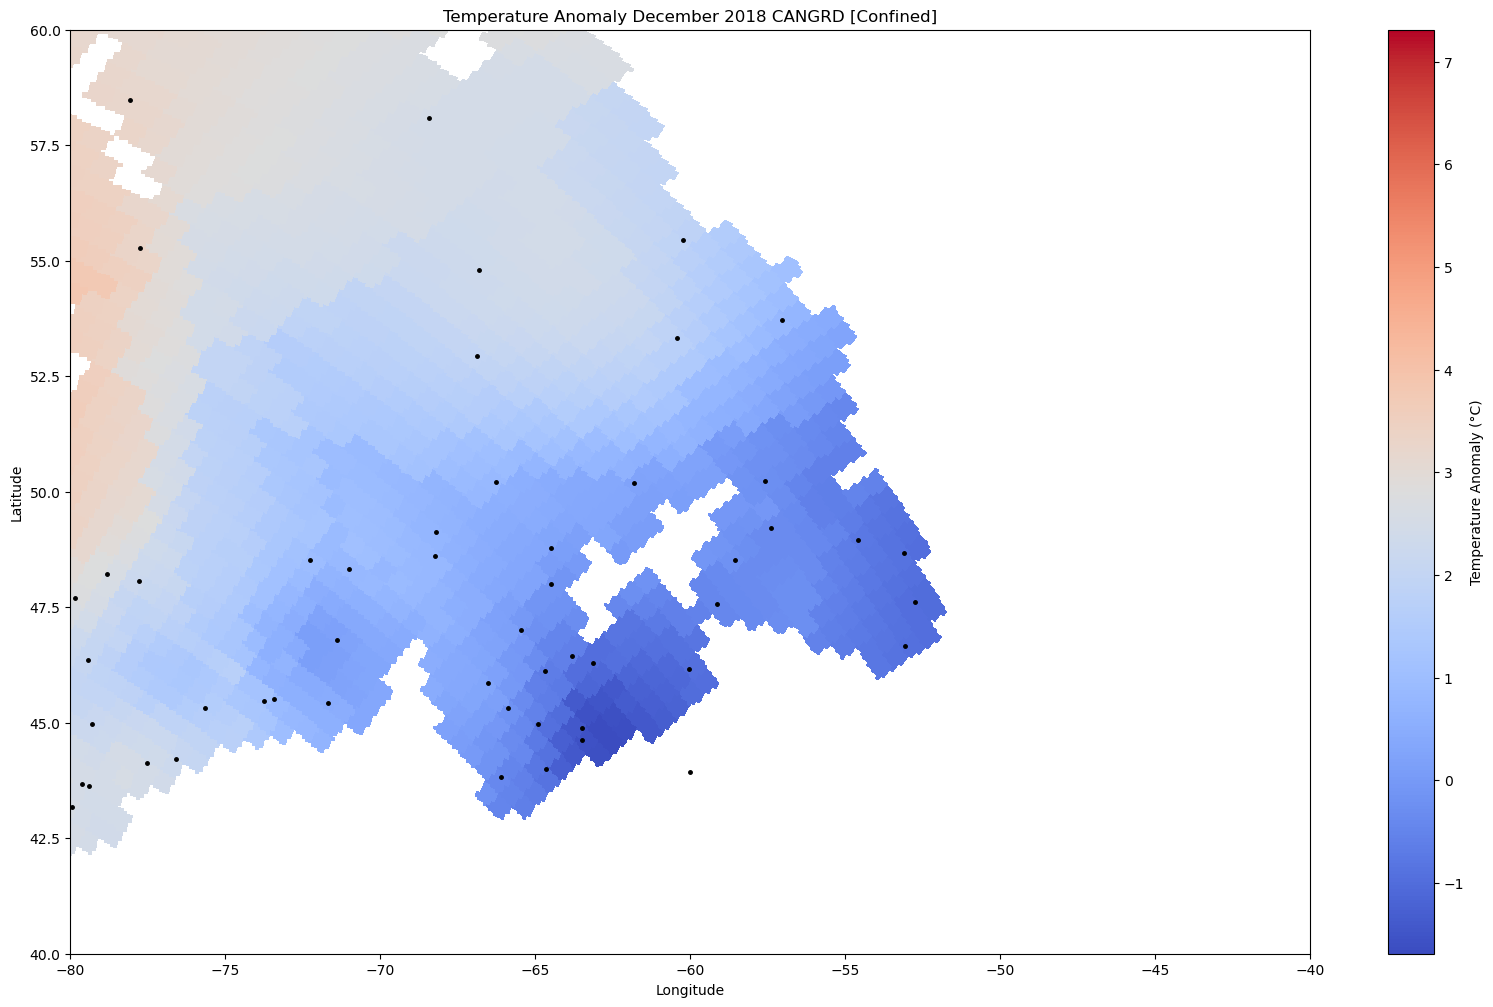

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pyproj import Proj, transform
import pandas as pd

wind_stations = pd.read_csv(r'/Users/maxMax/Desktop/Datasets/wind_stations1.csv')
ws_lat = wind_stations['lat (deg)'].values
ws_lon = wind_stations['long (deg)'].values

tif_path = r'/Users/maxMax/Desktop/Datasets/CANGRD_hist_monthly_anom_ps50km_TMEAN_2018-12.tif'
with rasterio.open(tif_path) as dataset:
    data = dataset.read(1)
    transform_matrix = dataset.transform #retrieves affinity transformation matrix (necessary for transforming coords)
    crs = dataset.crs #retrieves coord system used in dataset (polar stereographic)

masked_data = np.ma.masked_where(data == 9999.900000, data) #masking none vaalue data

# Define the source projection (Polar Stereographic) and target projection (Lat/Lon)
src_proj = Proj(crs)  #source coordinate reference system (CRS)
dst_proj = Proj(proj='latlong', datum='WGS84')#defining target CRS as lat/long specifically WGS84 (decimal coordinates)

rows, cols = data.shape #retrieves the rows and columns from data as arrays
x_coords, y_coords = np.meshgrid(np.arange(cols), np.arange(rows))#creates a meshgrid to access the x and y coordinates

x_proj, y_proj = rasterio.transform.xy(transform_matrix, y_coords, x_coords)#converting pixel indices (x,y) into real coordinates using the affine transformation matrix

x_proj_flat = np.array(x_proj).flatten() #converting x/y_proj into 1D arrays because pyproj only works with 1D arrays
y_proj_flat = np.array(y_proj).flatten()

lon, lat = transform(src_proj, dst_proj, x_proj_flat, y_proj_flat)#converting to WSG84 coordinates using pyproj

lon = np.reshape(lon, x_coords.shape)#reshapes 1D arrys back into their original 2d grid shapes
lat = np.reshape(lat, y_coords.shape)

plt.figure(figsize=(20, 12))
plt.pcolormesh(lon, lat, masked_data, cmap='coolwarm', shading='auto')
plt.colorbar(label='Temperature Anomaly (°C)')
plt.ylim(35, 90)
plt.xlim(-150, -40)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.scatter(ws_lon, ws_lat, color='black', s=25, marker='.') #showing location of Toronto
plt.title('Temperature Anomaly December 2018 CANGRD [Full]')
plt.show()

plt.figure(figsize=(20, 12))
plt.pcolormesh(lon, lat, masked_data, cmap='coolwarm', shading='auto')
plt.colorbar(label='Temperature Anomaly (°C)')
plt.ylim(40, 60)
plt.xlim(-80, -40)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.scatter(ws_lon, ws_lat, color='black', s=25, marker='.') #showing location of Toronto
plt.title('Temperature Anomaly December 2018 CANGRD [Confined]')
plt.show()